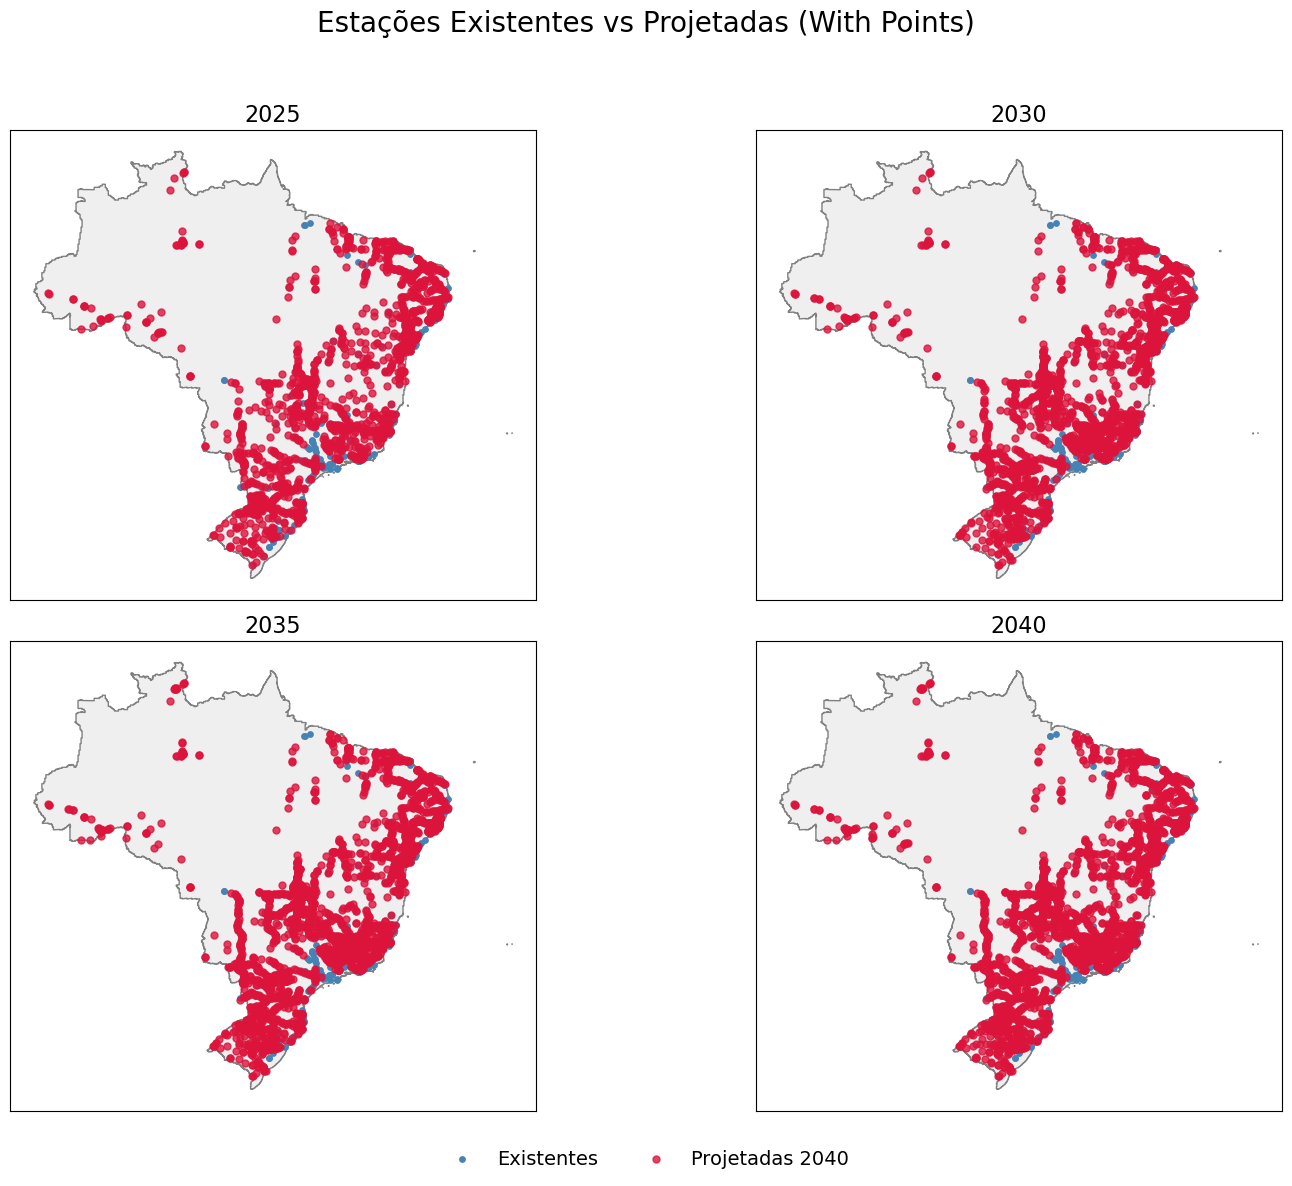

In [7]:
# %%  
# Cell: Map Visualization With Points (Jupyter)
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import geobr
from pathlib import Path

# ─── configurações gerais ───────────────────────────────
YEARS     = [2025, 2030, 2035, 2040]
BASE_DIR  = Path.cwd()  # deve ser a pasta `Projection`
# encontra cache/parquet
CUR = BASE_DIR
while CUR != CUR.parent:
    if (CUR / "cache" / "parquet").is_dir():
        CACHE = CUR / "cache"
        break
    CUR = CUR.parent
else:
    raise FileNotFoundError("Não achei cache/parquet acima de %s" % BASE_DIR)

PARQ        = CACHE / "parquet"
GRAPHML     = CACHE / "graph_Brazil.graphml"
SUPPLY_PARQ = PARQ / "supply_existing.parquet"
PROJ_ROOT   = PARQ / "Projection" / "WithFlow"

# ─── carrega Brasil (geometria) ─────────────────────────
br = geobr.read_country(year=2019).to_crs("EPSG:4326")

# ─── carrega grafo só pra extrair lon/lat ────────────────
G = ox.load_graphml(str(GRAPHML))
lon_map = {n: d["x"] for n, d in G.nodes(data=True)}
lat_map = {n: d["y"] for n, d in G.nodes(data=True)}

# ─── estações existentes ─────────────────────────────────
sup = pd.read_parquet(SUPPLY_PARQ)
sup["lon"] = sup["node"].map(lon_map)
sup["lat"] = sup["node"].map(lat_map)
g_exist = gpd.GeoDataFrame(
    sup, geometry=gpd.points_from_xy(sup.lon, sup.lat), crs="EPSG:4326"
)

# ─── cria figura 2×2 ─────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, year in zip(axes, YEARS):
    # fundo do Brasil
    br.plot(ax=ax, color="#EFEFEF", edgecolor="gray")
    # existentes em azul
    g_exist.plot(
        ax=ax, marker="o", color="steelblue", markersize=15,
        label="Existentes", zorder=2
    )
    # projetadas no ano
    proj_file = PROJ_ROOT / str(year) / f"sites_new_mip_withflow_{year}.parquet"
    if proj_file.exists():
        new = pd.read_parquet(proj_file)
        new["lon"] = new["node"].map(lon_map)
        new["lat"] = new["node"].map(lat_map)
        g_new = gpd.GeoDataFrame(
            new, geometry=gpd.points_from_xy(new.lon, new.lat), crs="EPSG:4326"
        )
        g_new.plot(
            ax=ax, marker="o", color="crimson", markersize=25,
            label=f"Projetadas {year}", alpha=0.8, zorder=3
        )
    else:
        # legenda vazia caso não haja projeção
        ax.plot([], [], 'o', color='crimson', label=f"Projetadas {year} (nenhuma)")

    ax.set_title(f"{year}", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

# título geral e legendas
fig.suptitle("Estações Existentes vs Projetadas (With Points)", fontsize=20)
# coloca legenda única no canto
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False, fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

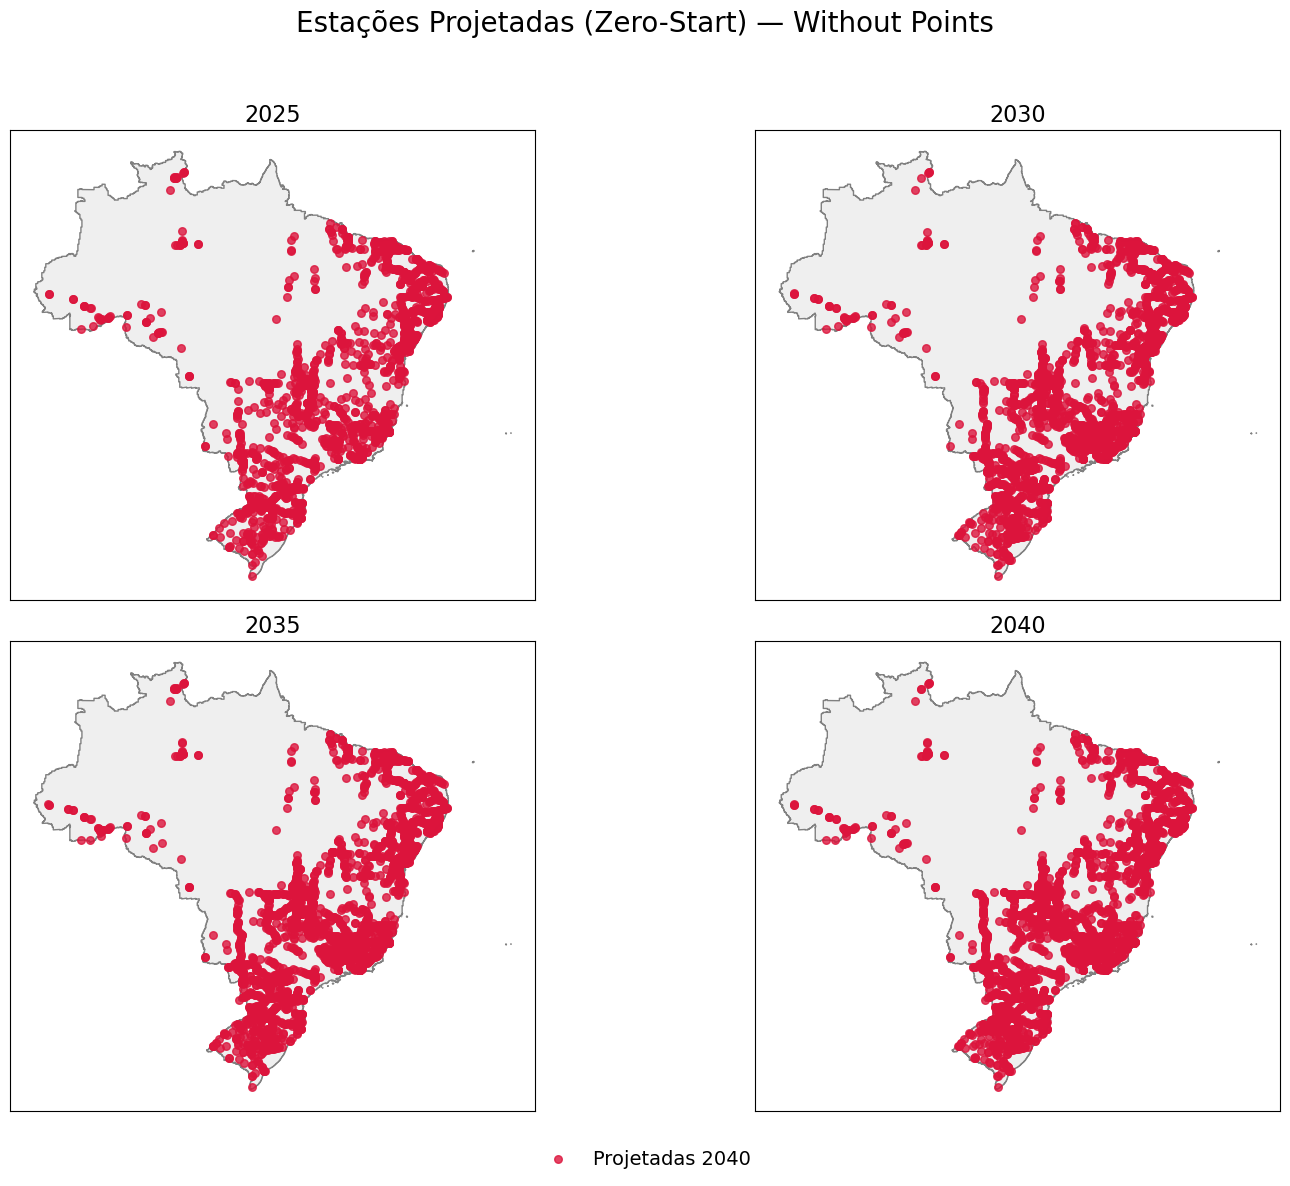

In [10]:
# %%  
# Cell: Map Visualization Without Points (Jupyter)
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import geobr
from pathlib import Path

# ─── configurações gerais ───────────────────────────────
YEARS    = [2025, 2030, 2035, 2040]
BASE_DIR = Path.cwd()  # deve ser a pasta `Projection`
# encontra cache/parquet
CUR = BASE_DIR
while CUR != CUR.parent:
    if (CUR / "cache" / "parquet").is_dir():
        CACHE = CUR / "cache"
        break
    CUR = CUR.parent
else:
    raise FileNotFoundError(f"Não achei cache/parquet acima de {BASE_DIR}")

PARQ      = CACHE / "parquet"
GRAPHML   = CACHE / "graph_Brazil.graphml"
PROJ_ROOT = PARQ / "Projection" / "WithoutFlow"

# ─── carrega Brasil (geometria) ─────────────────────────
br = geobr.read_country(year=2019).to_crs("EPSG:4326")

# ─── carrega grafo só pra extrair lon/lat ────────────────
G       = ox.load_graphml(str(GRAPHML))
lon_map = {n: d["x"] for n, d in G.nodes(data=True)}
lat_map = {n: d["y"] for n, d in G.nodes(data=True)}

# ─── monta figura 2×2 ───────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, year in zip(axes, YEARS):
    # desenha o Brasil
    br.plot(ax=ax, color="#EFEFEF", edgecolor="gray")

    # carrega projeção "scratch" para o ano
    proj_file = PROJ_ROOT / str(year) / f"sites_new_mip_scratch_{year}.parquet"
    if proj_file.exists():
        new = pd.read_parquet(proj_file)
        # mapeia lon/lat
        new["lon"] = new["node"].map(lon_map)
        new["lat"] = new["node"].map(lat_map)
        g_new = gpd.GeoDataFrame(
            new,
            geometry=gpd.points_from_xy(new.lon, new.lat),
            crs="EPSG:4326"
        )
        g_new.plot(
            ax=ax,
            marker="o",
            color="crimson",
            markersize=30,
            label=f"Projetadas {year}",
            alpha=0.8,
            zorder=3
        )
    else:
        # placeholder legend
        ax.plot([], [], 'o', color='crimson', label=f"Projetadas {year} (nenhuma)")

    ax.set_title(f"{year}", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

# título geral e legenda unificada
fig.suptitle("Estações Projetadas (Zero-Start) — Without Points", fontsize=20)
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False, fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()